In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
from DNN_utils import (flatten, column_str_to_numpy) 
from torch.utils.data import Dataset, DataLoader, sampler

import numpy as np 
import pandas as pd
from joblib import load 
import matplotlib.pyplot as plt

# Import helper functions.
import mfcc_label 
import get_prob


df_train = pd.read_csv('processed_data/dnn_never_train.csv')
df_test = pd.read_csv('processed_data/dnn_never_test.csv')

column_str_to_numpy(df_train, 'mfcc')
column_str_to_numpy(df_train, 'label')
column_str_to_numpy(df_test, 'mfcc')
column_str_to_numpy(df_test, 'label')

# Configurations 
NUM_TRAIN = int(0.8*len(df_train)) # Number of training examples for splitting training and validation datasets. 
NUM_ROWS = len(df_train)
device = 'cpu'
dtype = torch.float32
print_every = 50

# DNN Architecture Hyperparameters
minibatch_size = 64

In [88]:
display(df_train) 

,mfcc,label,state_weights
0,"[-730.505798, 45.0450668, -24.2304726, -16.595...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
1,"[-714.74677, 51.683174, -20.392345, -13.274165...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
2,"[-720.12866, 46.353207, -18.542915, -15.895822...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
3,"[-726.85284, 38.16919, -21.354225, -16.98072, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
4,"[-733.83295, 39.958935, -22.630146, -19.272156...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
...,...,...,...
15488,"[-773.1762, 4.0019016, 2.5322413, 2.8646927, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
15489,"[-773.2592, 4.076532, 2.7111504, 3.3019888, 4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
15490,"[-774.35565, 3.5023093, 3.4348507, 3.9783638, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}
15491,"[-774.29865, 4.247159, 3.8669136, 3.643158, 3....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'h#': 1.0}


In [13]:
load('processed_data/train_test_dataset_never.joblib')['test'] 

[('timit/data/TRAIN/DR2/FPJF0/SX146.WAV',
  'timit/data/TRAIN/DR2/FPJF0/SX146.PHN',
  'timit/data/TRAIN/DR2/FPJF0/SX146.WRD'),
 ('timit/data/TRAIN/DR3/MDBB1/SX376.WAV',
  'timit/data/TRAIN/DR3/MDBB1/SX376.PHN',
  'timit/data/TRAIN/DR3/MDBB1/SX376.WRD'),
 ('timit/data/TRAIN/DR5/MPMB0/SX61.WAV',
  'timit/data/TRAIN/DR5/MPMB0/SX61.PHN',
  'timit/data/TRAIN/DR5/MPMB0/SX61.WRD'),
 ('timit/data/TRAIN/DR4/MJLS0/SX376.WAV',
  'timit/data/TRAIN/DR4/MJLS0/SX376.PHN',
  'timit/data/TRAIN/DR4/MJLS0/SX376.WRD'),
 ('timit/data/TRAIN/DR3/MTJM0/SX146.WAV',
  'timit/data/TRAIN/DR3/MTJM0/SX146.PHN',
  'timit/data/TRAIN/DR3/MTJM0/SX146.WRD'),
 ('timit/data/TRAIN/DR7/MBBR0/SX425.WAV',
  'timit/data/TRAIN/DR7/MBBR0/SX425.PHN',
  'timit/data/TRAIN/DR7/MBBR0/SX425.WRD'),
 ('timit/data/TRAIN/DR5/FCDR1/SX376.WAV',
  'timit/data/TRAIN/DR5/FCDR1/SX376.PHN',
  'timit/data/TRAIN/DR5/FCDR1/SX376.WRD'),
 ('timit/data/TRAIN/DR4/MLJC0/SI1855.WAV',
  'timit/data/TRAIN/DR4/MLJC0/SI1855.PHN',
  'timit/data/TRAIN/DR4/MLJC

In [16]:
class DNN_FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        # We may write a loop if we use the same activation function for all layers.
        self.fc1 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc2.weight) 
        self.fc3 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.fc5 = nn.Linear(input_size, num_classes)
        nn.init.kaiming_normal_(self.fc5.weight)
    
    def forward(self, x):
        x_temp = x
        x_temp = flatten(x_temp)
        x_temp = F.relu(self.fc1(x_temp))
        x_temp = F.relu(self.fc2(x_temp))
        x_temp = F.relu(self.fc3(x_temp))
        x_temp = F.relu(self.fc4(x_temp))
        scores = self.fc5(x_temp)
        return scores


def test_DNN_FC():
    input_size = len(df_train.iloc[0]['mfcc'])  # Feature dimension for mfcc
    num_classes = len(df_train.iloc[0]['label']) # Number of phoneme classes
    dtype = torch.float32
    x = torch.zeros((minibatch_size, input_size), dtype=dtype)  # minibatch size 64, feature dimension 20
    model = DNN_FC(input_size, num_classes)
    scores = model(x)
    print(scores.size())  # you should see [minibatch_size, num_classes]
test_DNN_FC()

torch.Size([64, 14])


In [28]:
# Convert dataset into a format that torch can read.
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        # Convert the DataFrame to tensors or appropriate formats initially
        self.mfcc = torch.tensor(np.vstack(dataframe['mfcc'].to_list()), dtype=torch.float32)
        self.label = torch.tensor(np.vstack(dataframe['label'].to_list()), dtype=torch.long)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.mfcc)

    def __getitem__(self, idx):
        mfcc = self.mfcc[idx]
        label = self.label[idx]
        
        if self.transform:
            mfcc = self.transform(mfcc)

        return mfcc, label

# Create an instance of your dataset with your DataFrame
dataset_train = CustomDataset(df_train,train=True)  # Assuming df is your pandas DataFrame
dataset_test = CustomDataset(df_test,train=False)

# Create the DataLoader to handle batching
loader_train = DataLoader(dataset_train, batch_size=minibatch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Create the DataLoader to handle batching
loader_val = DataLoader(dataset_train, batch_size=1,
                        sampler=sampler.SequentialSampler(range(NUM_TRAIN, len(df_train))))

loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

In [103]:
# Example code to print the contents of the first few batches in loader_train

for i, (inputs, labels) in enumerate(loader_train):
    print(f"Batch {i + 1}")
    print(f"Features (MFCCs) size: {inputs.size()}")
    print(f"Labels size: {labels.size()}")
    print("\n") 
    
    # Optional: Stop after a few batches to avoid flooding the output
    if i == 2:  # Adjust this number based on how many batches you want to see
        break


Batch 1
Features (MFCCs) size: torch.Size([64, 20])
Labels size: torch.Size([64, 14])


Batch 2
Features (MFCCs) size: torch.Size([64, 20])
Labels size: torch.Size([64, 14])


Batch 3
Features (MFCCs) size: torch.Size([64, 20])
Labels size: torch.Size([64, 14])




In [65]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            y = flatten(y) # Flatten y to convert dimension from (NxCxH) to (N,-1)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype) 
            scores = model(x) 
            _, preds = scores.max(1) 
            true_class = y.argmax(dim=1) # True class is the one that has the highest probability in the label vector y.
            num_correct += (preds == true_class).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc 

def check_loss(loader, model):
    '''
    Check the loss in a given loader (e.g. validation loss)
    Args:
        loader: Loader object for tranining, validation or test sets.
        model: Our model (e.g. DNN)
    Returns:
        loss: Loss calculated with the dataset given by loader (e.g. validation dataset).
    '''
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            y = flatten(y)
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            scores = model(x)
            criterion = nn.BCEWithLogitsLoss() 
            total_loss = criterion(scores, y)
    
    return total_loss
            


        

In [104]:
device = 'cpu'
dtype = torch.float32

def train(model, optimizer, epochs=1):
    """
    Train the model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_loss_lst = []
    train_loss_lst = []
    accuracy_val_max = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            y = flatten(y) # Flatten y to convert the dimension from (Nx1) to (N,)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)

            # Compare the output vector with the label vector using BCEwithLogitsLoss.
            criterion = nn.BCEWithLogitsLoss() 
            loss = criterion(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()
                accuracy_val = check_accuracy(loader_val, model)
                val_loss = check_loss(loader_val, model) 
                if accuracy_val > accuracy_val_max:
                    accuracy_val_max = accuracy_val
                    model_params = model.state_dict()
                train_loss_lst.append(loss.item())
                val_loss_lst.append(val_loss.item()) 

    # Plot the accuracy values
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.plot(train_loss_lst, label='Training Loss')

    # Add labels and title to the plot
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.show()
    return train_loss_lst, val_loss_lst
    
    


Iteration 0, loss = 25.8664

Checking accuracy on validation set
Got 1920 / 3099 correct (61.96)
Iteration 50, loss = 0.1611

Checking accuracy on validation set
Got 1898 / 3099 correct (61.25)
Iteration 100, loss = 0.0878

Checking accuracy on validation set
Got 1925 / 3099 correct (62.12)
Iteration 150, loss = 0.0762

Checking accuracy on validation set
Got 1929 / 3099 correct (62.25)
Iteration 0, loss = 0.0760

Checking accuracy on validation set
Got 1995 / 3099 correct (64.38)
Iteration 50, loss = 0.0714

Checking accuracy on validation set
Got 1989 / 3099 correct (64.18)
Iteration 100, loss = 0.0681

Checking accuracy on validation set
Got 2049 / 3099 correct (66.12)
Iteration 150, loss = 0.0631

Checking accuracy on validation set
Got 1989 / 3099 correct (64.18)
Iteration 0, loss = 0.0572

Checking accuracy on validation set
Got 2066 / 3099 correct (66.67)
Iteration 50, loss = 0.0764

Checking accuracy on validation set
Got 2066 / 3099 correct (66.67)
Iteration 100, loss = 0.0522

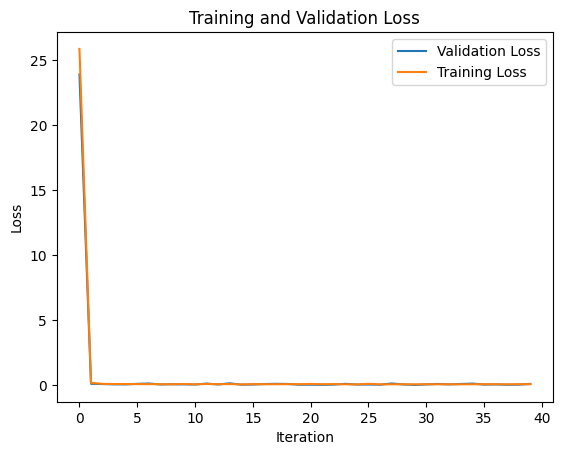

In [105]:
input_size = len(df_train['mfcc'][0])
num_classes = len(df_train['label'][0])
learning_rate = 1e-2
model = DNN_FC(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss_lst, val_loss_lst = train(model, optimizer,epochs = 10) 

# Accuracy on the validation set: 72.57%. 

[(0, 132.12843322753906), (50, 0.18589463829994202), (100, 0.0990721732378006), (150, 0.08073507994413376), (0, 0.06793185323476791), (50, 0.1110951155424118), (100, 0.09869115054607391), (150, 0.07687275111675262), (0, 0.07738903909921646), (50, 0.07590685784816742), (100, 0.06693124026060104), (150, 0.07869281619787216), (0, 0.08949099481105804), (50, 0.06368806213140488), (100, 0.056478869169950485), (150, 0.06149466708302498), (0, 0.05575072765350342), (50, 0.09910876303911209), (100, 0.07669363170862198), (150, 0.08487699925899506), (0, 0.08218448609113693), (50, 0.05274364724755287), (100, 0.06331469118595123), (150, 0.061663899570703506), (0, 0.0614713653922081), (50, 0.08693607896566391), (100, 0.059040870517492294), (150, 0.05784987658262253), (0, 0.05884968489408493), (50, 0.04776263236999512), (100, 0.06655866652727127), (150, 0.056188635528087616), (0, 0.06981917470693588), (50, 0.06152039021253586), (100, 0.06271477788686752), (150, 0.06057360768318176), (0, 0.065824680030

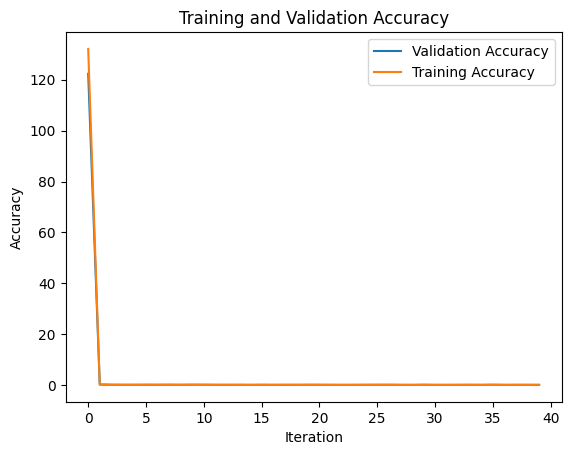

In [85]:
print(train_loss_lst)
print(val_loss_lst) 
x_train, y_train = zip(*train_loss_lst)
x_val, y_val = zip(*val_loss_lst)

# Plot the accuracy values
plt.plot(y_val, label='Validation Loss')
plt.plot(y_train, label='Training Loss')

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()




In [32]:
def infer_probabilities(loader, model):
    if loader.dataset.train:
        print('Getting estimated probabilities on validation set')
    else:
        print('Getting estimated probabilities on test set') 
    model.eval()  # set model to evaluation mode
    probabilities_dict = {} 
    batch_size = loader.batch_size
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            y = flatten(y) # Flatten y to convert dimension from (Nx1) to (N,)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype) 
            scores = model(x) 
            probabilities = torch.softmax(scores, dim=1) 
            
            # Save the probabilities with the corresponding row index
            for i in range(len(probabilities)):
                probabilities_dict[idx * batch_size + i] = probabilities[i].numpy()
    
    return probabilities_dict


def find_emission(loader, model, scale = False):
    '''
    Find emission probabilities for a given data loader and model.
    Consider changing this function if it takes too long. Currently: O(n) 
    Args:
        loader: torch Data loader
        model: torch DNN model
        scale: Boolean: Set true to scale the output probability of DNN.
    Returns:
        emission_df: Dataframe for emission probabilities.
    '''
    # Get the inferred probabilities for each class (12 states, background and silence)
    probabilities_dict = infer_probabilities(loader, model) 
    emission = probabilities_dict
    # Get the prior vector and the transition probabilities. We don't need the transition probabilities.
    prior_vector, _ = get_prob.main(rerun=False) 

    # For each key=row_idx and val=prob_array, convert the inferred probabilities into emission.
    for key, val in emission.items():
        # Slice val to exclude the probabilities for background and silence.
        if scale == True:
            log_prob = np.where(val > 0, np.log(val), -np.inf)   # Get the log probabilities. 
            log_prob = log_prob[:-2]  # Exclude the background and silence in the emission probability calculation. 
            emission[key] = [log_prob-prior_vector]  # Divide by prior vector in the log space. 
        else:
            emission[key] = [val] 

    emission_df = pd.DataFrame.from_dict(emission, orient='index', columns=['Emission']) 
    return emission_df 

In [33]:
prior_vector, _ = get_prob.main(rerun=True)
estimate_prob = infer_probabilities(loader_test, model)
emission_data = find_emission(loader_test, model)


For start 45760 and end 46160, there is no time-overlapping row.
For start 65120 and end 65520, there is no time-overlapping row.
For start 35440 and end 35840, there is no time-overlapping row.
For start 42480 and end 42880, there is no time-overlapping row.
For start 49040 and end 49440, there is no time-overlapping row.
For start 59200 and end 59600, there is no time-overlapping row.
For start 61040 and end 61440, there is no time-overlapping row.
For start 39840 and end 40240, there is no time-overlapping row.
For start 46800 and end 47200, there is no time-overlapping row.
For start 60640 and end 61040, there is no time-overlapping row.
For start 56240 and end 56640, there is no time-overlapping row.
For start 52240 and end 52640, there is no time-overlapping row.
Getting estimated probabilities on test set
Getting estimated probabilities on test set


In [34]:
def path_to_emission(file_path_wav: str, file_path_phn: str):
    '''
    Given the path of a file, get the emission probabilities.
    Args:
        file_path: Path of the audio file as a string.
    Returns:
        emit: pd.dataframe
            Emission probabilities for each frame in the audio file.
    '''
    df_test = mfcc_label.prepare_data(file_path_phn,file_path_wav)
    column_str_to_numpy(df_test, 'mfcc')
    column_str_to_numpy(df_test, 'label')
    # Convert dataframe into a loader so that torch can work with.
    dataset_test = CustomDataset(df_test,train=False)
    loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

    emission_data = find_emission(loader_test, model)
    return emission_data
    

path_to_emission('timit/data/TRAIN/DR4/MDCD0/SX425.WAV','timit/data/TRAIN/DR4/MDCD0/SX425.PHN')

Getting estimated probabilities on test set


,Emission
0,"[4.6042454e-09, 3.837383e-13, 4.5595003e-09, 1..."
1,"[9.414626e-12, 9.017476e-15, 4.019678e-08, 2.6..."
2,"[5.282601e-12, 1.4799697e-14, 8.797442e-08, 2...."
3,"[4.876087e-13, 8.0470126e-16, 1.550741e-08, 8...."
4,"[1.5715532e-12, 1.4153545e-15, 1.1340891e-08, ..."
...,...
402,"[1.0229477e-08, 2.0857027e-12, 7.428098e-09, 1..."
403,"[3.5222934e-07, 1.0310169e-10, 8.804566e-08, 9..."
404,"[1.302162e-06, 8.295634e-10, 4.97092e-07, 0.00..."
405,"[9.547573e-08, 3.7362613e-11, 1.5992927e-07, 6..."


In [35]:
def get_emission_all_paths(path_type: str = 'test'):
    paths = load('processed_data/train_test_dataset_never.joblib')[path_type]
    data = {}
    for i in range(len(paths)):
        file_path_wav, file_path_phn, file_path_word = paths[i]
        emission_data = path_to_emission(file_path_wav, file_path_phn)
        data[(file_path_wav, file_path_phn, file_path_word)] = emission_data

    return data
data = get_emission_all_paths() 

from joblib import dump
dump(data, "processed_data/test_data_for_hmm.joblib")

For start 36960 and end 37360, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 36960 and end 37360
Getting estimated probabilities on test set
For start 45760 and end 46160, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 45760 and end 46160
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
For start 62960 and end 63360, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 62960 and end 63360
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estima

['processed_data/test_data_for_hmm.joblib']